# Dance Comments

In [175]:
#!/usr/bin/env python

from __future__ import print_function

import os
import sys
import time
import json
import requests
import argparse
import lxml.html
import os.path
import re
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import pandas as pd
import datetime as dt
import nltk
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline
from textblob import TextBlob as tb

from lxml.cssselect import CSSSelector

YOUTUBE_COMMENTS_URL = 'https://www.youtube.com/all_comments?v={youtube_id}'
YOUTUBE_COMMENTS_AJAX_URL = 'https://www.youtube.com/comment_ajax'

USER_AGENT = 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36'

def find_value(html, key, num_chars=2):
    pos_begin = html.find(key) + len(key) + num_chars
    pos_end = html.find('"', pos_begin)
    return html[pos_begin: pos_end]


def extract_comments(html):
    tree = lxml.html.fromstring(html)
    item_sel = CSSSelector('.comment-item')
    text_sel = CSSSelector('.comment-text-content')
    time_sel = CSSSelector('.time')
    author_sel = CSSSelector('.user-name')

    for item in item_sel(tree):
        yield {'cid': item.get('data-cid'),
               'text': text_sel(item)[0].text_content(),
               'time': time_sel(item)[0].text_content().strip(),
               'author': author_sel(item)[0].text_content()}


def extract_reply_cids(html):
    tree = lxml.html.fromstring(html)
    sel = CSSSelector('.comment-replies-header > .load-comments')
    return [i.get('data-cid') for i in sel(tree)]


def ajax_request(session, url, params, data, retries=10, sleep=20):
    for _ in range(retries):
        response = session.post(url, params=params, data=data)
        if response.status_code == 200:
            response_dict = json.loads(response.text)
            return response_dict.get('page_token', None), response_dict['html_content']
        else:
            time.sleep(sleep)
            
#Get the sentiment
def get_sentiment_from_comment(text):
        b = tb(text)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

def get_sentiments_from_all_comments(comments):
       return list(map(get_sentiment_from_comment, comments))


def download_comments(youtube_id, sleep=1):
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT

    # Get Youtube page with initial comments
    response = session.get(YOUTUBE_COMMENTS_URL.format(youtube_id=youtube_id))
    html = response.text
    reply_cids = extract_reply_cids(html)

    ret_cids = []
    for comment in extract_comments(html):
        ret_cids.append(comment['cid'])
        yield comment

    page_token = find_value(html, 'data-token')
    session_token = find_value(html, 'XSRF_TOKEN', 4)

    first_iteration = True

    # Get remaining comments (the same as pressing the 'Show more' button)
    while page_token:
        data = {'video_id': youtube_id,
                'session_token': session_token}

        params = {'action_load_comments': 1,
                  'order_by_time': True,
                  'filter': youtube_id}

        if first_iteration:
            params['order_menu'] = True
        else:
            data['page_token'] = page_token

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL, params, data)
        if not response:
            break

        page_token, html = response

        reply_cids += extract_reply_cids(html)
        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment

        first_iteration = False
        time.sleep(sleep)

    # Get replies (the same as pressing the 'View all X replies' link)
    for cid in reply_cids:
        data = {'comment_id': cid,
                'video_id': youtube_id,
                'can_reply': 1,
                'session_token': session_token}

        params = {'action_load_replies': 1,
                  'order_by_time': True,
                  'filter': youtube_id,
                  'tab': 'inbox'}

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL, params, data)
        if not response:
            break

        _, html = response

        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment
        time.sleep(sleep)
        
#Loop through the larger array and strip the comments & get sentiment
def helper(all_comments):
    for comment_list in all_comments:
        strip_comment(comment_list)
        print (get_sentiments_from_all_comments(comment_list))

#Strip comments of unnecesary characters
def strip_comment(list):
    for i in range (len(list)):
        list[i] = list[i].strip('\ufeff')
        print (list[i])
        
def youtube_parser(youtube_id, max_comments=200):
    parser = argparse.ArgumentParser(add_help=False, description=('Download Youtube comments without using the Youtube API'))
    parser.add_argument('--help', '-h', action='help', default=argparse.SUPPRESS, help='Show this help message and exit')
    parser.add_argument('--youtubeid', '-y', help='ID of Youtube video for which to download the comments')
    parser.add_argument('--output', '-o', help='Output filename (output format is line delimited JSON)')

    try:

        if not youtube_id:
            parser.print_usage()
            raise ValueError('you need to specify a Youtube ID')

        print('Downloading Youtube comments for video:', youtube_id)
        count = 0
        comments = []
        #loop through the comments 
        for comment in download_comments(youtube_id):
            if count > max_comments:
                break
            try:
                comments.append(json.dumps(comment))
                count += 1
                sys.stdout.write('Downloaded %d comment(s)\r' % count)
                sys.stdout.flush()
            except Exception as e:
                sys.stdout.write('Encountered an error; returning %d comment(s)\r' % count)
                break
        
        return list(map(lambda x: json.loads(x)['text'], comments))

    except Exception as e:
        print('Error:', str(e))
        sys.exit(1)


#if __name__ == "__main__":
#    main(sys.argv[1:])


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [176]:
#Hip Hop 1: SYTYCD My Chick Bad
all_comments = []
video_id = 'hATakt0zOzg'
hip_1_comments = youtube_parser(video_id)
all_comments.append(hip_1_comments)

In [177]:
#Hip Hop 2: SYTYCD Outta Your Mind
video_id = 'TLtSfYX8tJk'
hip_2_comments = youtube_parser(video_id)
all_comments.append(hip_2_comments)

In [178]:
#Hip Hop 3: SYTYCD Hello Good Morning
video_id = 'tCb_UOakEQI'
hip_3_comments = youtube_parser(video_id)
all_comments.append(hip_3_comments)

In [179]:
#Contemporary 1: SYTYCD Hallelujah
video_id = 'G8u8xPLar-E'
contemp_1_comments = youtube_parser(video_id)
all_comments.append(contemp_1_comments)

In [180]:
#Contemporary 2: SYTYCD Medicine
video_id = 'RQ11mwgbReE'
contemp_2_comments = youtube_parser(video_id)
all_comments.append(contemp_2_comments)

In [181]:
#Contemporary 3: SYTYCD Wicked Game
video_id = 'khvcCpoFszM'
contemp_3_comments = youtube_parser(video_id)
all_comments.append(contemp_3_comments)

In [182]:
helper(all_comments)

LOVE LOVE LOVE THIS SO MUCH
She is literally one of the hottest people I ever seen
i love this one its so amazing i also love this song
After some time I always come back to this! <3
yeah they should of won I'm still annoyed they got robbed by Ellen
Does any one know if TWITCH is teaching...ANYWHERE??  Is he on FB, On Line, Where??
Last time I checked he was on Ellen
Does anyone know what remix this is, I need the exact song. Thanks :)
My Chick Bad - Ludacris ft. Nicki Minaj
Does anyone know what remix this is, I need the exact song. Thanks :)
One of my two favorite dancers❤️🙌🏼
I've watched this a zillion times ! Love it !
Holy crap she's back?!?
They both dance good
bonigom romivom elobob

Love it!! 
So excited that Lauren is returning as an all star this season!  And dancing with Ricky!  Holy crap.
THEY CAN DANCCCCCE
Wow...She completely out danced him in his own style !!!
Yes, she was great. However, completely out danced him, is a bit extreme...
TruLeo is right, Twitch is an all st

[-0.55714285714285716, 0.10000000000000001, 0.31111111111111112, 0.69999999999999996, 1.062121212121212, 0.0, 0.0, 0.83333333333333326, 1.0, 1.0, 0.60000000000000009, 0.43333333333333335, 1.0, 0.75, 0.39999999999999997, 0.69999999999999996, 0.0, 0.5, 0.25, 0.0, -0.20000000000000001, 0.17499999999999999, -0.125, 0.0, 0.17499999999999999, 0.0, 0.0, 0.25, 0.0, 0.0, 0.25, 0.25, 0.86481481481481493, 0.0, 0.0, 0.5, -0.125, 0.625, -0.090476190476190432, 0.19318181818181818, 0.0, 0.25, 0.80000000000000004, 0.80000000000000004, 0.25, 0.34999999999999998, 0.55000000000000004, -0.049999999999999989, 0.0, 0.90000000000000002, 0.75333333333333341, -0.033333333333333326, -0.099999999999999978, 0.85000000000000009, 0.0, 0.0, 0.0, 0.25, 1.25, 0.0, -0.40000000000000002, 0.0, -0.58333333333333348, 0.0, -0.70625000000000004, 0.016666666666666677, 0.0, 0.5, 0.63636363636363635, 0.34999999999999998, 0.80000000000000004, 0.0, 0.93750000000000011, 0.5, 1.4642857142857144, 1.125, 0.0, 1.3999999999999999, -1.3

[1.0, 0.0, 0.90000000000000002, 0.5, 1.0875000000000001, 0.20000000000000001, 1.0, -0.75, 0.5, 0.0, 0.0, 0.0, -0.20000000000000001, -0.23333333333333328, 0.125, -0.75, 0.5, 1.45, 0.0, 0.10714285714285714, 0.0, 0.20000000000000001, 0.0, 0.0, 0.5, 0.90000000000000002, 0.375, 0.125, 0.0, 0.42499999999999999, 0.41666666666666669, 0.0, 0.84999999999999998, 0.18461538461538465, 0.15000000000000002, -0.016666666666666663, 0.0, -0.3125, 0.43333333333333335, 0.5, -0.75, 2.0, 0.0, 0.29999999999999999, 0.84999999999999998, 0.84999999999999998, -0.40000000000000002, 0.57499999999999996, 0.0, 0.0, 0.49999999999999994, 0.65000000000000002, -0.80000000000000004, 0.10000000000000001, -0.20000000000000001, -0.79999999999999993, 0.8348214285714286, 0.0, 0.01666666666666667, -0.25, 0.0, 0.43500000000000005, 0.10000000000000001, 0.0, 0.0, 0.0, 0.0, -1.25, 0.45833333333333337, -0.16666666666666669, 1.6499999999999999, -0.20000000000000001, 0.55000000000000004, 0.0, -0.40000000000000002, 0.0, 0.174999999999

YESS
SAMEEE
YESSSSSS SAAAAAAMMMMEEEE
💖 💖 💖
I've never had professional dance instruction or training, but everything about the chemistry and synchonicity of this dance makes me love the art. the profession. the beauty that is dance.
wow its like they freezed the time in 1:27 when they slowed down
That was sooo powerful and amazing! Thank you!
Rip my soul out and leave it on the floor like always Travis Walls! I could watch this routine over and over and it gets better and better
1:25 That was the most beautiful turn I've ever seen!! And they were so in sync and so well timed with it. Ahhh I'm just flustered😍
I keep coming back to this for that turn alone <3
Meravigliosi;-)
OMG Amyy you are amazing!!!!!  the best dance ever <3
maravilhoso. ..
speachless / perfection / it's just unreal ❤❤ its an extention of this song.
Perfect 😍
1:33 OMG!!!!!!
1:25 TELL ME THIS DIDN'T GIVE YOU CHILLS.
Thank you so much Fierce Wanderer! What is wrong with audiences today, that they are hooting and holleri

In [183]:
# sent_list = [1.0, 0.0, 0.90000000000000002, 0.5, 1.0875000000000001, 0.20000000000000001, 1.0, -0.75, 0.5, 0.0, 0.0, 0.0, -0.20000000000000001, -0.23333333333333328, 0.125, -0.75, 0.5, 1.45, 0.0, 0.10714285714285714, 0.0, 0.20000000000000001, 0.0, 0.0, 0.5, 0.90000000000000002, 0.375, 0.125, 0.0, 0.42499999999999999, 0.41666666666666669, 0.0, 0.84999999999999998, 0.18461538461538465, 0.15000000000000002, -0.016666666666666663, 0.0, -0.3125, 0.43333333333333335, 0.5, -0.75, 2.0, 0.0, 0.29999999999999999, 0.84999999999999998, 0.84999999999999998, -0.40000000000000002, 0.57499999999999996, 0.0, 0.0, 0.49999999999999994, 0.65000000000000002, -0.80000000000000004, 0.10000000000000001, -0.20000000000000001, -0.79999999999999993, 0.8348214285714286, 0.0, 0.01666666666666667, -0.25, 0.0, 0.43500000000000005, 0.10000000000000001, 0.0, 0.0, 0.0, 0.0, -1.25, 0.45833333333333337, -0.16666666666666669, 1.6499999999999999, -0.20000000000000001, 0.55000000000000004, 0.0, -0.40000000000000002, 0.0, 0.17499999999999999, 1.4875, 0.88124999999999998, 0.0, -0.75, 0.0, 0.10000000000000001, 0.375, -0.03125, 0.0, 0.0, -0.10000000000000001, -0.55000000000000004, -0.20000000000000001, 0.6166666666666667, 1.6000000000000001, 0.40000000000000002, 0.30517578125, 0.0, 0.66666666666666663, 0.25, 0.82499999999999996, 0.29999999999999999, 0.040000000000000015, -0.55000000000000004, 1.0416666666666665, -0.049999999999999989, 1.1000000000000001, 1.0, -0.85572916666666676, 0.69999999999999996, 0.29999999999999999, 0.5, 0.0, -0.075000000000000011, 0.40000000000000002, -1.3875, 0.5, 0.0, 0.068181818181818177, 0.0, 0.0, 0.72500000000000009, 0.4375, 1.335, 1.7292857142857145, 0.0, 0.2857142857142857, 0.0, 1.0, 0.41666666666666669, 0.34999999999999998, 1.25, 0.21428571428571427, 0.41666666666666669, 0.0, 0.69999999999999996, 1.4722222222222223, -0.5, 1.5750000000000002, -0.26666666666666666, -0.09375, 0.0, 0.60000000000000009, 0.0, 0.80000000000000004, 0.65000000000000002, 0.45833333333333326, 0.5, -0.55000000000000004, 1.1000000000000001, 0.45000000000000001, 0.0, 0.96666666666666679, 0.0, 0.0, 2.2750000000000004, 0.3666666666666667, 0.75, -0.20000000000000001, 0.19999999999999998, 0.0, 0.0, 0.0, 0.69999999999999996, 0.0, 0.75000000000000011, 0.0, 1.25, 2.2000000000000002, 1.0, 0.56666666666666665, 0.5, 0.0, 2.0, 0.0, 0.8222222222222223, 0.0, -0.79999999999999993, 1.5, 1.0499999999999998, -1.2142857142857142, 0.0, 0.625, 0.75, 0.0, 0.0, 0.20000000000000001, 0.23392857142857143, 0.1875, 0.5625, 0.55000000000000004, 0.0, 2.1875, 0.20000000000000001, 0.52500000000000002, 0.75656565656565666, -0.016666666666666607, 0.5, 0.36249999999999999, 0.33750000000000002, 1.3166666666666667, 0.20000000000000001, -0.5, 0.80000000000000004]

# sentiment_counter(sent_list)

In [184]:
my_chick_bad_sentiment = ["0.42499999999999999", "0.0", "0.53333333333333333", "1.0", "-0.40000000000000002", "0.0", "0.0", "0.59999999999999998", "-0.69999999999999984", "0.59999999999999998", "0.5", "0.625", "-0.40000000000000002", "0.69999999999999996", "0.0", "0.625", "-0.33125000000000004", "0.0", "0.51875000000000004", "0.78750000000000009", "1.779220779220779", "0.80000000000000004", "1.7", "0.34999999999999998", "0.4375", "0.1875", "1.0", "0.050000000000000003", "0.0", "0.52500000000000002", "0.0", "-0.4777777777777778", "0.0", "0.5", "0.0", "0.25"]

sentiment_counter(my_chick_bad_sentiment)

Negative Sentiments:  5
Positive Sentiments:  31


In [185]:
outta_your_mind_sentiment = ["-0.55714285714285716", "0.10000000000000001", "0.31111111111111112", "0.69999999999999996", "1.062121212121212", "0.0", "0.0", "0.83333333333333326", "1.0", "1.0", "0.60000000000000009", "0.43333333333333335", "1.0", "0.75", "0.39999999999999997", "0.69999999999999996", "0.0", "0.5", "0.25", "0.0", "-0.20000000000000001", "0.17499999999999999", "-0.125", "0.0", "0.17499999999999999", "0.0", "0.0", "0.25", "0.0", "0.0", "0.25", "0.25", "0.86481481481481493", "0.0", "0.0", "0.5", "-0.125", "0.625", "-0.090476190476190432", "0.19318181818181818", "0.0", "0.25", "0.80000000000000004", "0.80000000000000004", "0.25", "0.34999999999999998", "0.55000000000000004", "-0.049999999999999989", "0.0", "0.90000000000000002", "0.75333333333333341", "-0.033333333333333326", "-0.099999999999999978", "0.85000000000000009", "0.0", "0.0", "0.0", "0.25", "1.25", "0.0", "-0.40000000000000002", "0.0", "-0.58333333333333348", "0.0", "-0.70625000000000004", "0.016666666666666677", "0.0", "0.5", "0.63636363636363635", "0.34999999999999998", "0.80000000000000004", "0.0", "0.93750000000000011", "0.5", "1.4642857142857144", "1.125", "0.0", "1.3999999999999999", "-1.3999999999999999", "0.5", "0.69999999999999996", "0.875", "1.0", "0.0", "0.55000000000000004", "0.55000000000000004", "0.93125000000000002", "0.5", "1.0", "0.0", "1.0", "1.0", "0.20000000000000001", "0.5", "0.0", "0.80000000000000004", "0.0", "1.0", "0.0", "0.69999999999999996", "1.0", "0.34999999999999998", "-0.20000000000000001", "1.125", "0.90000000000000013", "2.2999999999999998", "0.0", "0.69999999999999996", "0.52499999999999991", "0.75", "1.0", "0.0", "1.0", "0.17499999999999999", "0.0", "0.0", "0.80000000000000004", "0.20000000000000001", "0.0", "0.0", "0.32500000000000001", "0.1875", "0.0", "0.72916666666666674", "0.5", "0.0", "0.0", "0.80000000000000004", "0.0", "-0.1953125", "0.80000000000000004", "0.0", "0.75", "0.375", "0.75", "1.0", "2.5", "0.25", "1.5", "0.0", "0.25", "0.5", "1.0", "-0.25", "1.0", "0.43333333333333335", "0.0", "0.5", "0.0", "0.0", "0.625", "0.0", "0.125", "0.0", "0.69999999999999996", "0.0", "0.0", "0.0", "0.5", "0.0", "0.0", "0.0", "0.5", "1.0", "0.5", "-0.22361111111111115", "0.0", "0.67500000000000004", "0.60000000000000009", "0.0", "-0.015384615384615385", "0.0", "0.0", "0.59999999999999998", "1.125", "0.0", "1.0", "0.0", "-0.390625", "0.0", "0.625", "0.0", "1.0", "-0.1875", "0.5", "0.0", "0.5", "1.0", "0.0", "0.0", "0.69999999999999996", "0.25", "0.0", "1.0", "0.80000000000000004", "0.0", "-0.3125", "-0.3125", "0.0", "0.0", "0.69999999999999996"]

sentiment_counter(outta_your_mind_sentiment)

Negative Sentiments:  21
Positive Sentiments:  180


In [186]:
hello_good_morning_sentiment = ["1.4848484848484849", "0.0", "-0.20000000000000001", "-0.5", "0.0", "0.0", "0.0", "0.69999999999999996", "0.0", "0.0", "0.050000000000000003", "0.0", "0.0", "0.34999999999999998", "1.75", "-0.5", "0.0", "-0.35714285714285715", "0.0", "0.0", "0.5", "1.0", "0.5", "0.78125", "0.0", "0.5", "-0.25", "0.0", "0.0", "0.0", "0.0", "0.10000000000000001", "0.390625", "1.0", "1.3333333333333333", "0.0", "-0.013095238095238104", "-0.4375", "0.55000000000000004", "0.5", "0.0", "0.25", "0.0", "0.0", "0.5", "0.60000000000000009", "0.0", "0.25", "0.5", "0.0", "0.0", "-0.375", "-0.375", "0.0", "0.0", "0.0", "1.5", "0.0", "0.0", "0.0", "0.20000000000000001", "-0.5", "0.80000000000000004", "0.0", "0.75", "0.39375000000000004", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.69999999999999996", "0.80000000000000004"]

sentiment_counter(hello_good_morning_sentiment)

Negative Sentiments:  10
Positive Sentiments:  64


In [ ]:
hallelujah_sentiment =  ["1.0, 0.0, 0.90000000000000002, 0.5, 1.0875000000000001, 0.20000000000000001, 1.0, -0.75, 0.5, 0.0, 0.0, 0.0, -0.20000000000000001, -0.23333333333333328, 0.125, -0.75, 0.5, 1.45, 0.0, 0.10714285714285714, 0.0, 0.20000000000000001, 0.0, 0.0, 0.5, 0.90000000000000002, 0.375, 0.125, 0.0, 0.42499999999999999, 0.41666666666666669, 0.0, 0.84999999999999998, 0.18461538461538465, 0.15000000000000002, -0.016666666666666663, 0.0, -0.3125, 0.43333333333333335, 0.5, -0.75, 2.0, 0.0, 0.29999999999999999, 0.84999999999999998, 0.84999999999999998, -0.40000000000000002, 0.57499999999999996, 0.0, 0.0, 0.49999999999999994, 0.65000000000000002, -0.80000000000000004, 0.10000000000000001, -0.20000000000000001, -0.79999999999999993, 0.8348214285714286, 0.0, 0.01666666666666667, -0.25, 0.0, 0.43500000000000005, 0.10000000000000001, 0.0, 0.0, 0.0, 0.0, -1.25, 0.45833333333333337, -0.16666666666666669, 1.6499999999999999, -0.20000000000000001, 0.55000000000000004, 0.0, -0.40000000000000002, 0.0, 0.17499999999999999, 1.4875, 0.88124999999999998, 0.0, -0.75, 0.0, 0.10000000000000001, 0.375, -0.03125, 0.0, 0.0, -0.10000000000000001, -0.55000000000000004, -0.20000000000000001, 0.6166666666666667, 1.6000000000000001, 0.40000000000000002, 0.30517578125, 0.0, 0.66666666666666663, 0.25, 0.82499999999999996, 0.29999999999999999, 0.040000000000000015, -0.55000000000000004, 1.0416666666666665, -0.049999999999999989, 1.1000000000000001, 1.0, -0.85572916666666676, 0.69999999999999996, 0.29999999999999999, 0.5, 0.0, -0.075000000000000011, 0.40000000000000002, -1.3875, 0.5, 0.0, 0.068181818181818177, 0.0, 0.0, 0.72500000000000009, 0.4375, 1.335, 1.7292857142857145, 0.0, 0.2857142857142857, 0.0, 1.0, 0.41666666666666669, 0.34999999999999998, 1.25, 0.21428571428571427, 0.41666666666666669, 0.0, 0.69999999999999996, 1.4722222222222223, -0.5, 1.5750000000000002, -0.26666666666666666, -0.09375, 0.0, 0.60000000000000009", "0.0", "0.80000000000000004", "0.65000000000000002", "0.45833333333333326", "0.5", "-0.55000000000000004", "1.1000000000000001", "0.45000000000000001", "0.0", "0.96666666666666679", "0.0", "0.0", "2.2750000000000004", "0.3666666666666667", "0.75", "-0.20000000000000001", "0.19999999999999998", "0.0", "0.0", "0.0", "0.69999999999999996", "0.0", "0.75000000000000011", "0.0", "1.25", "2.2000000000000002", "1.0", "0.56666666666666665", "0.5", "0.0", "2.0", "0.0", "0.8222222222222223", "0.0", "-0.79999999999999993", "1.5", "1.0499999999999998", "-1.2142857142857142", "0.0", "0.625", "0.75", "0.0", "0.0", "0.20000000000000001", "0.23392857142857143", "0.1875", "0.5625", "0.55000000000000004", "0.0", "2.1875", "0.20000000000000001", "0.52500000000000002", "0.75656565656565666", "-0.016666666666666607", "0.5", "0.36249999999999999", "0.33750000000000002", "1.3166666666666667", "0.20000000000000001", "-0.5", "0.80000000000000004"]

sentiment_counter(hallelujah_sentiment)

In [187]:
medicine_sentiment = ["0.14999999999999999", "1.5", "0.0", "0.0", "0.0", "0.0", "0.84999999999999998", "0.0", "0.60000000000000009", "0.0", "0.0", "0.25", "1.0", "1.2421875", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.125", "0.125", "0.80000000000000004", "0.0"]

sentiment_counter(medicine_sentiment)

Negative Sentiments:  0
Positive Sentiments:  24


In [190]:
wicked_game_sentiment = ["0.45000000000000001", "0.0", "0.0", "0.0", "0.0", "0.0", "0.20000000000000001", "0.60000000000000009", "0.0", "0.60624999999999996", "0.20000000000000001", "0.84999999999999998", "0.0", "0.20000000000000001", "0.0", "0.10000000000000001", "0.97500000000000009", "0.0", "0.10000000000000001", "-0.17000000000000001", "0.21666666666666673", "0.0", "0.6333333333333333", "0.0", "0.0", "0.0", "0.84999999999999998", "1.0", "0.0", "0.41666666666666669", "1.6000000000000001", "0.0", "0.84999999999999998", "0.84999999999999998", "0.0", "0.050000000000000003", "0.0", "0.47499999999999998", "0.0", "0.0", "0.0", "1.6875", "0.0", "1.8500000000000001", "0.0", "0.0", "0.0", "0.43333333333333335", "0.5", "0.0", "0.5", "1.625", "0.42499999999999999", "0.0", "0.0", "0.5", "0.0", "0.0", "-0.10000000000000001", "0.50555555555555554", "0.64000000000000012", "0.0", "0.5", "0.0", "0.5", "1.0", "0.84635416666666652", "0.29166666666666669", "1.5", "0.0", "-0.20000000000000001", "1.2999999999999998", "0.16666666666666666", "0.0", "0.35000000000000003", "0.53333333333333344", "1.4199999999999999", "0.5", "0.38500000000000001", "0.60000000000000009", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.625", "1.0", "0.0", "0.0", "0.0", "0.0", "0.5", "0.5", "0.27500000000000002", "1.4669070512820515", "-0.16562500000000002", "0.0", "0.5", "1.0", "0.0", "1.05", "0.0", "0.0", "0.14999999999999999", "1.0", "0.10000000000000001", "0.28750000000000003", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.29999999999999999", "-0.02777777777777779", "0.52500000000000002", "0.5", "0.75", "0.5", "0.25", "2.0", "0.0", "0.0", "1.0", "0.0", "0.0", "-0.25", "0.0", "0.0", "0.2857142857142857", "0.16666666666666666", "0.84999999999999998", "0.0", "0.59999999999999998", "0.0", "-0.099999999999999867", "0.0", "0.29999999999999999", "0.0", "0.0", "0.0", "0.9185267857142857", "0.84999999999999998", "0.0", "-0.10000000000000001", "0.0", "0.0", "0.0", "0.049999999999999989", "0.0625", "-0.025000000000000001", "-1.0446666666666666", "0.34999999999999998", "0.4375", "0.84999999999999998", "0.29999999999999999", "0.0", "0.0", "1.5", "0.40000000000000008", "0.0", "0.0", "0.0", "0.65000000000000002", "0.0", "0.0", "0.25", "1.5", "1.25", "0.0", "0.0", "-0.40000000000000002", "0.84999999999999998", "0.0", "1.0", "0.0", "0.0", "1.0", "0.5", "0.625", "0.0", "0.5", "0.0", "0.5", "1.0", "0.20000000000000001", "0.0", "0.5", "0.0", "0.80000000000000004", "1.0", "0.0", "0.59999999999999998", "0.58750000000000002", "0.68660714285714286", "0.375", "0.0"]
sentiment_counter(wicked_game_sentiment)

Negative Sentiments:  11
Positive Sentiments:  190


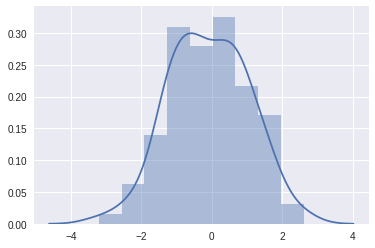

In [98]:
x = np.random.normal(size=100)
sns.distplot(x);

IndexError: too many indices for array

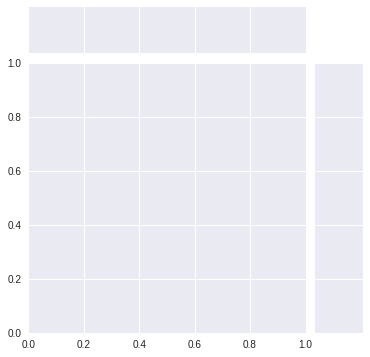

In [100]:
# h = sns.jointplot(x=np.array(get_sentiments_from_all_comments), y=np.array(all_comments), kind='reg');
# h.set_axis_labels(xlabel='Sentiment', ylabel='Number of comments (' + info['stocks'][0]['currency'] + ')');

In [ ]:
#Get comments from Instagram
#Get comments from YouTube

In [ ]:
#Loop through the comments on Instagram to find the most common words used 
#Loop through the comments on YouTube to find the most common words used

In [ ]:
#Analyze the sentiment of the comments

In [ ]:
#I will pick one hip hop video and one ballet video and find the most common words used

In [ ]:
#I will get comments from other videos without looking at them first and try to predict what style 
#of dance the video is based on the words used in the comments